In [ ]:
!pip install keras-tuner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import (
    roc_auc_score, classification_report,
    confusion_matrix,
    precision_recall_curve, auc
)
!pip install lime shap keras-tuner
import lime
import lime.lime_tabular
import shap

import keras_tuner as kt
import io

In [ ]:
print('GPU available:',tf.config.list_physical_devices('GPU'))

GPU available: []


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Train.csv to Train.csv


In [ ]:
data = pd.read_csv(io.BytesIO(uploaded['Train.csv']))
data.head()

,ID,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,74768,LP002231,1,1,0,1,0,8328,0.000000,17,363,1,2,1,6000
1,79428,LP001448,1,1,0,0,0,150,3857.458782,188,370,1,1,0,6000
2,70497,LP002231,0,0,0,0,0,4989,314.472511,17,348,1,0,0,6000
3,87480,LP001385,1,1,0,0,0,150,0.000000,232,359,1,1,1,3750
4,33964,LP002231,1,1,1,0,0,8059,0.000000,17,372,1,0,1,3750


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5898 entries, 0 to 5897
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 5898 non-null   int64  
 1   Loan_ID            5898 non-null   object 
 2   Gender             5898 non-null   int64  
 3   Married            5898 non-null   int64  
 4   Dependents         5898 non-null   object 
 5   Education          5898 non-null   int64  
 6   Self_Employed      5898 non-null   int64  
 7   ApplicantIncome    5898 non-null   int64  
 8   CoapplicantIncome  5898 non-null   float64
 9   LoanAmount         5898 non-null   int64  
 10  Loan_Amount_Term   5898 non-null   int64  
 11  Credit_History     5898 non-null   int64  
 12  Property_Area      5898 non-null   int64  
 13  Loan_Status        5898 non-null   int64  
 14  Total_Income       5898 non-null   int64  
dtypes: float64(1), int64(12), object(2)
memory usage: 691.3+ KB


In [ ]:
data.shape

(5898, 15)

In [ ]:
print(f'columns: {data.columns}')

columns: Index(['ID', 'Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'Total_Income'],
      dtype='object')


In [ ]:
print(f'data types: \n{data.dtypes}')

data types: 
ID                     int64
Loan_ID               object
Gender                 int64
Married                int64
Dependents            object
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount             int64
Loan_Amount_Term       int64
Credit_History         int64
Property_Area          int64
Loan_Status            int64
Total_Income           int64
dtype: object


In [ ]:
data['Dependents'] = data['Dependents'].replace('3+', 3)

print(data['Dependents'].unique())
data = data.drop('Loan_ID', axis=1)
data.dtypes

['0' '1' 3 '2']


,0
ID,int64
Gender,int64
Married,int64
Dependents,object
Education,int64
Self_Employed,int64
ApplicantIncome,int64
CoapplicantIncome,float64
LoanAmount,int64
Loan_Amount_Term,int64


In [ ]:
print(f'missing values: \n{data.isnull().sum()}')

missing values: 
ID                   0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
Total_Income         0
dtype: int64


In [ ]:
target = data['Loan_Status']
print(f'target distribution:\n', data['Loan_Status'].value_counts())

target distribution:
 Loan_Status
1    4913
0     985
Name: count, dtype: int64


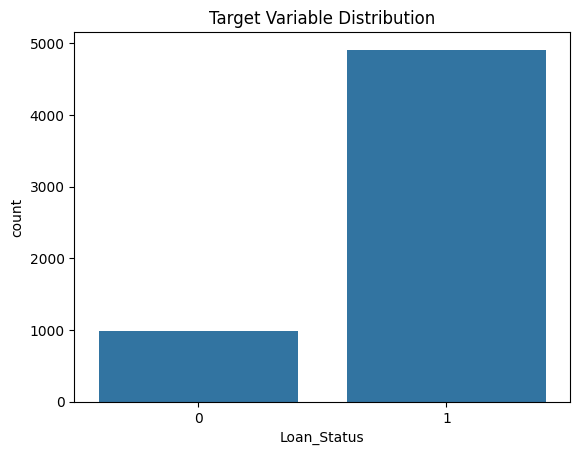

In [ ]:
sns.countplot(x='Loan_Status', data=data)
plt.title('Target Variable Distribution')
plt.show()

In [ ]:
data.describe()

,ID,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
count,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000
mean,54964.183452,0.910817,0.854527,0.120210,0.107664,7782.026958,1245.954548,97.410478,359.114954,0.920482,1.183961,0.832994,5239.284503
std,26133.640949,0.285032,0.352607,0.325235,0.309981,9182.571831,2368.012349,103.483478,48.876088,0.270569,0.730568,0.373013,2308.679455
min,10002.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,17.000000,12.000000,0.000000,0.000000,0.000000,1963.000000
25%,32337.000000,1.000000,1.000000,0.000000,0.000000,2342.250000,0.000000,17.000000,357.000000,1.000000,1.000000,1.000000,3750.000000
50%,55501.000000,1.000000,1.000000,0.000000,0.000000,6989.000000,117.562275,42.000000,368.000000,1.000000,1.000000,1.000000,6000.000000
75%,77775.750000,1.000000,1.000000,0.000000,0.000000,8375.000000,1680.894542,174.000000,372.000000,1.000000,2.000000,1.000000,6000.000000
max,99998.000000,1.000000,1.000000,1.000000,1.000000,81000.000000,20000.000000,700.000000,480.000000,1.000000,2.000000,1.000000,22500.000000


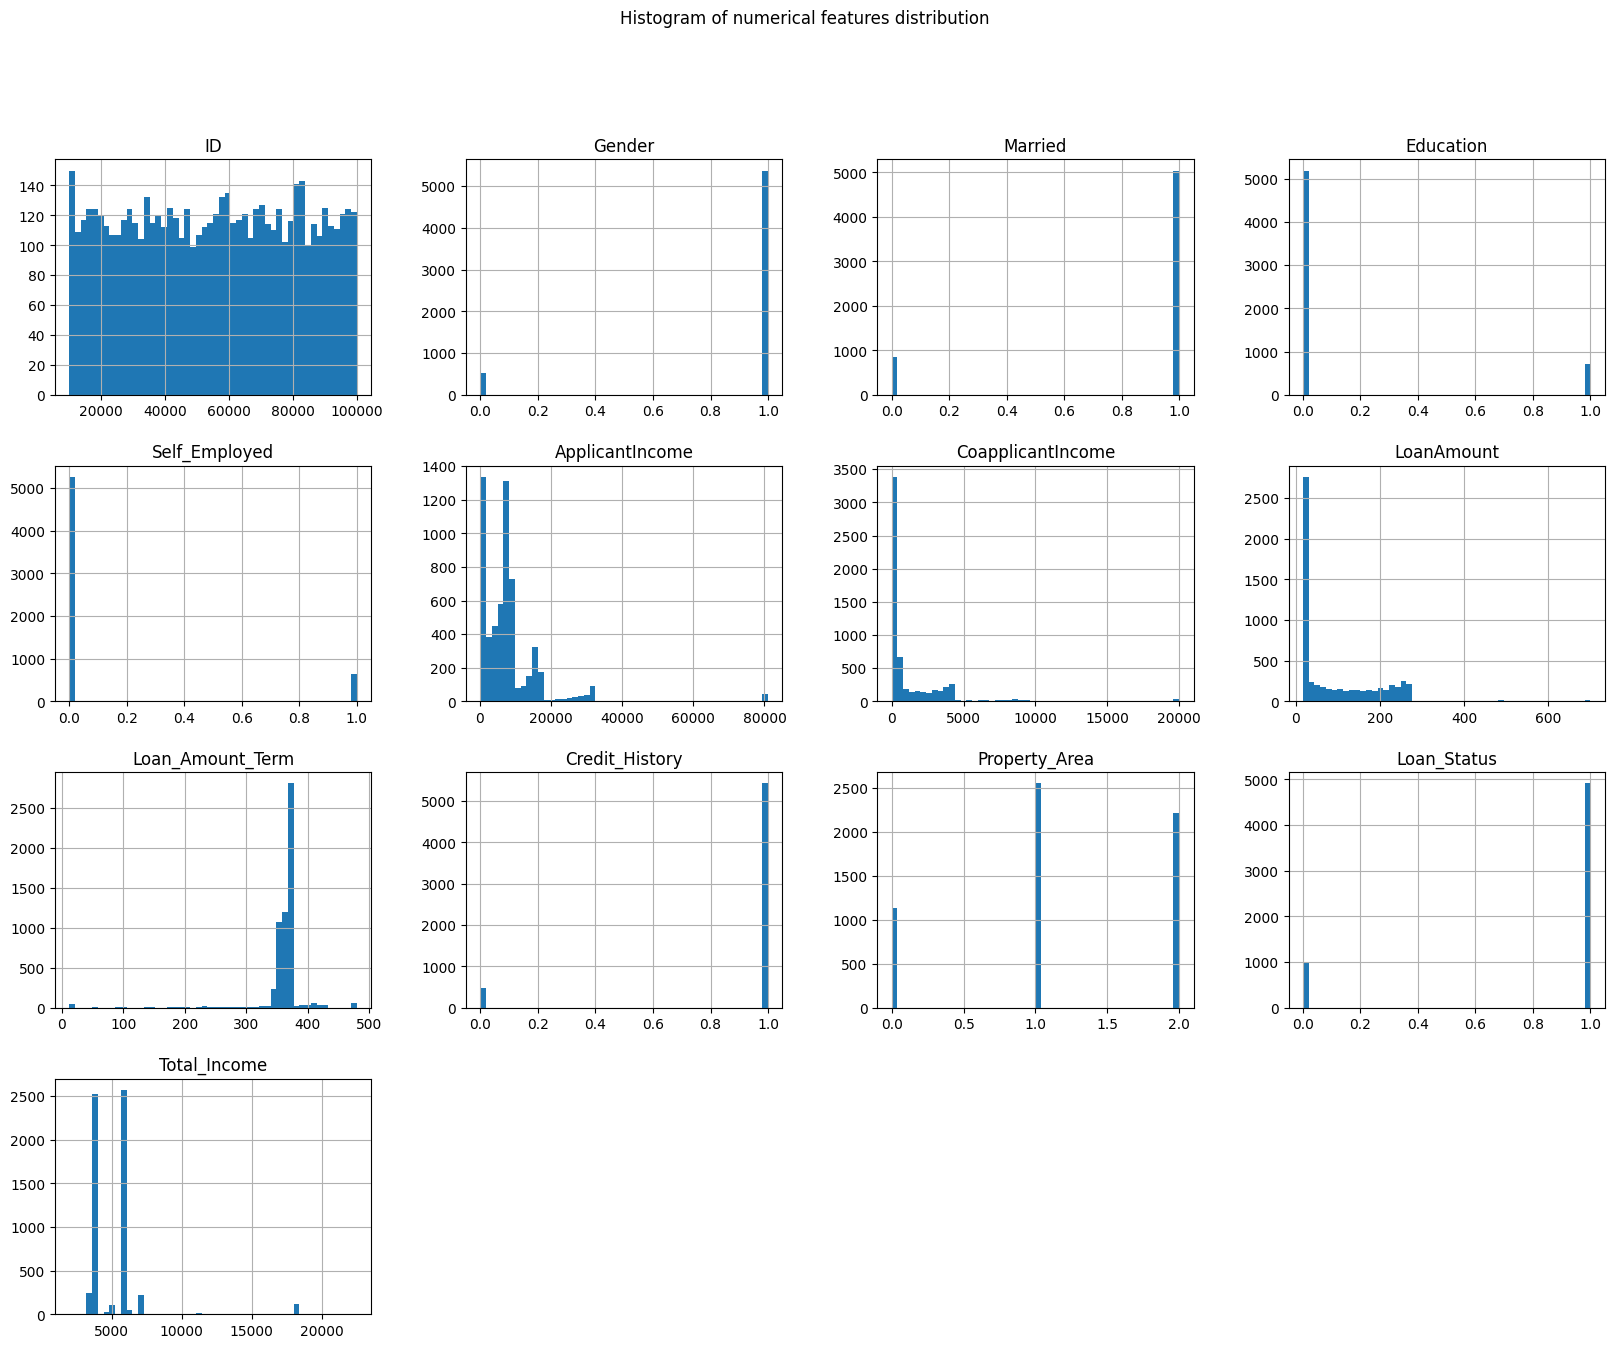

In [ ]:
data.hist(bins=50, figsize=(20,15))
plt.suptitle('Histogram of numerical features distribution')
plt.show()

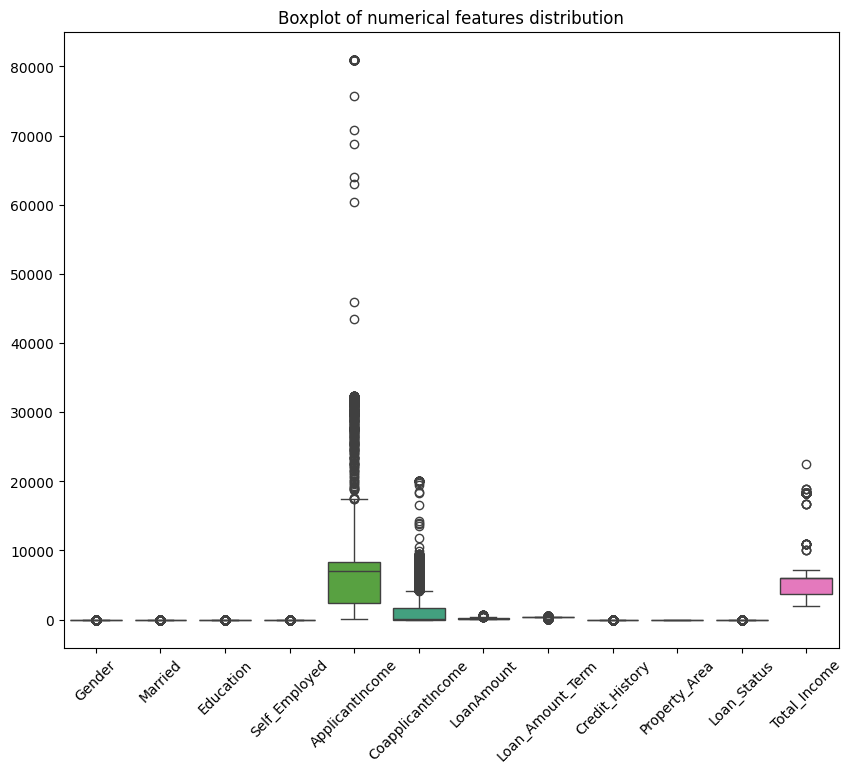

In [ ]:
# boxplot to check for outliers
plt.figure(figsize=(10, 8))
sns.boxplot(data=data.drop(columns=['ID']))
plt.title('Boxplot of numerical features distribution')
plt.xticks(rotation=45)
plt.show()

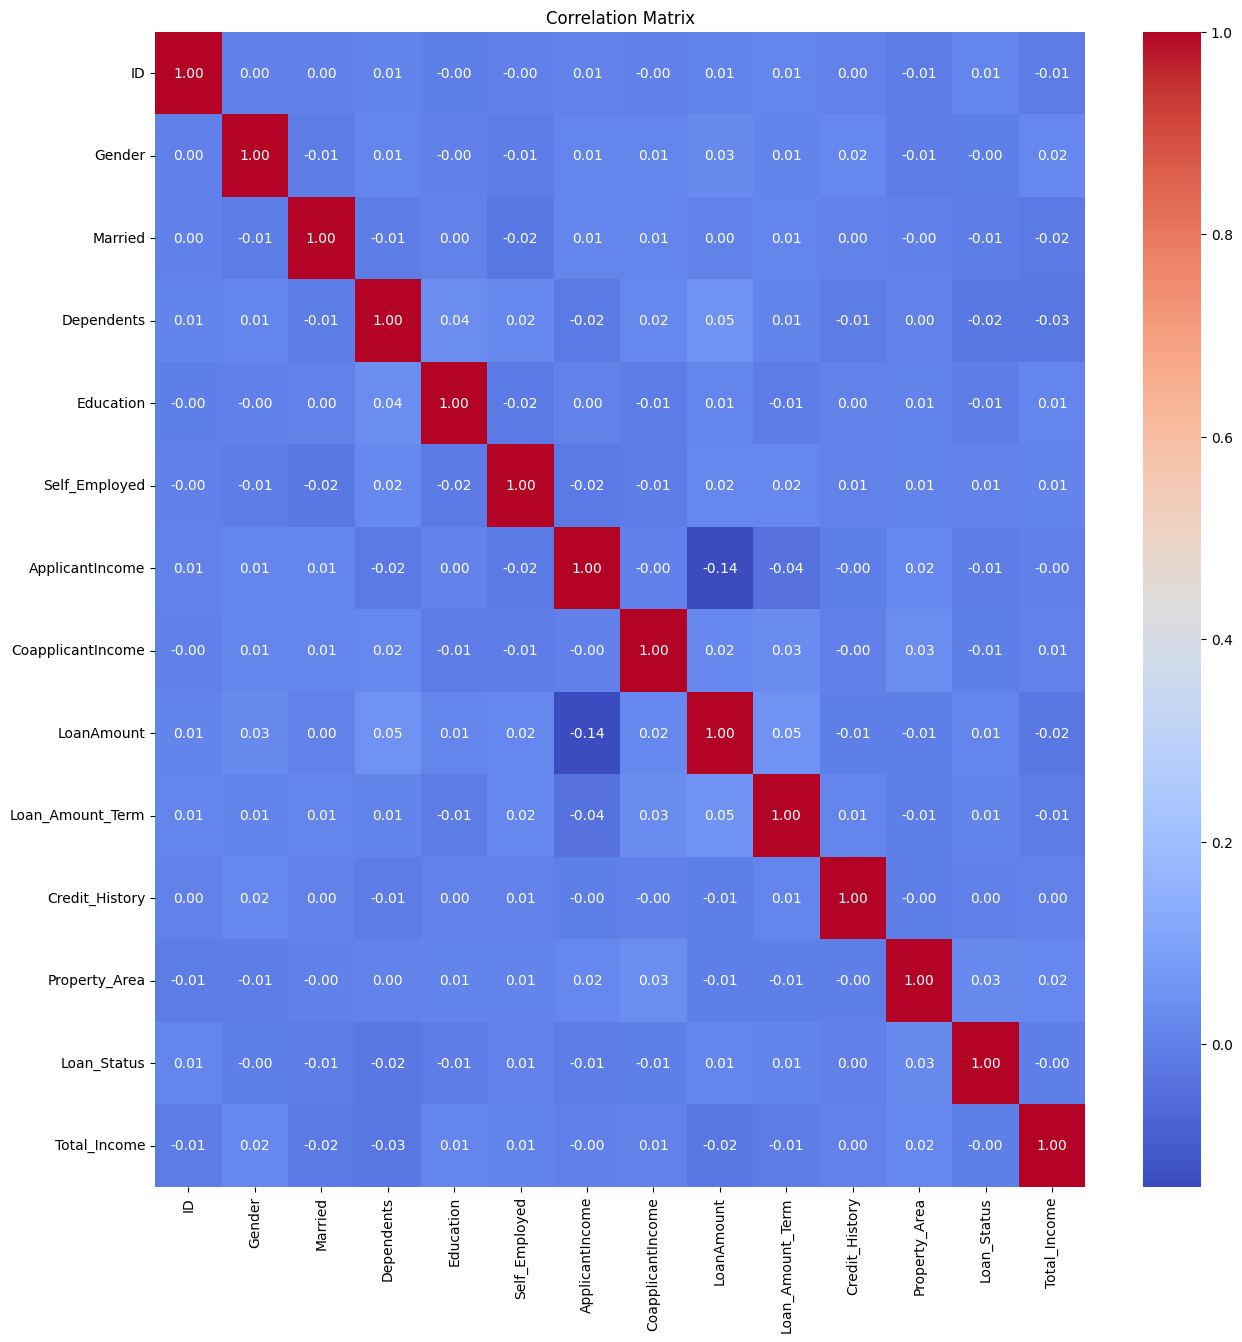

correlations with target variables:/n Loan_Status          1.000000
Property_Area        0.026883
LoanAmount           0.014613
ID                   0.012332
Loan_Amount_Term     0.008299
Self_Employed        0.005938
Credit_History       0.001133
Gender              -0.004538
Total_Income        -0.004700
CoapplicantIncome   -0.007058
Married             -0.008111
ApplicantIncome     -0.009189
Education           -0.010613
Dependents          -0.021859
Name: Loan_Status, dtype: float64


In [ ]:
# Correlation matrix between features and target value
corr_matrix = data.corr()
plt.figure(figsize =(15,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

print('correlations with target variables:/n', corr_matrix['Loan_Status'].sort_values(ascending=False))
# corr_matrix

In [ ]:
data.to_csv('cleaned_train.csv', index=False)

In [ ]:
try:
    df = pd.read_csv('cleaned_train.csv')
    print(df.head())
except FileNotFoundError:
    print("Error: 'cleaned_train.csv' not found. Please upload or provide the correct path.")

      ID  Gender  Married  Dependents  Education  Self_Employed  \
0  74768       1        1           0          1              0   
1  79428       1        1           0          0              0   
2  70497       0        0           0          0              0   
3  87480       1        1           0          0              0   
4  33964       1        1           1          0              0   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             8328           0.000000          17               363   
1              150        3857.458782         188               370   
2             4989         314.472511          17               348   
3              150           0.000000         232               359   
4             8059           0.000000          17               372   

   Credit_History  Property_Area  Loan_Status  Total_Income  
0               1              2            1          6000  
1               1              1            0 

In [ ]:
for col in ['Total_Income', 'ApplicantIncome', 'CoapplicantIncome']:
    df[col + '_log'] = np.log1p(data[col])

df.head()

,ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Total_Income_log,ApplicantIncome_log,CoapplicantIncome_log
0,74768,1,1,0,1,0,8328,0.000000,17,363,1,2,1,6000,8.699681,9.027499,0.000000
1,79428,1,1,0,0,0,150,3857.458782,188,370,1,1,0,6000,8.699681,5.017280,8.258023
2,70497,0,0,0,0,0,4989,314.472511,17,348,1,0,0,6000,8.699681,8.515191,5.754072
3,87480,1,1,0,0,0,150,0.000000,232,359,1,1,1,3750,8.229778,5.017280,0.000000
4,33964,1,1,1,0,0,8059,0.000000,17,372,1,0,1,3750,8.229778,8.994669,0.000000


In [ ]:
df = df.drop(['ApplicantIncome', 'CoapplicantIncome', 'ID', 'Total_Income'], axis=1)
df.head()

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income_log,ApplicantIncome_log,CoapplicantIncome_log
0,1,1,0,1,0,17,363,1,2,1,8.699681,9.027499,0.000000
1,1,1,0,0,0,188,370,1,1,0,8.699681,5.017280,8.258023
2,0,0,0,0,0,17,348,1,0,0,8.699681,8.515191,5.754072
3,1,1,0,0,0,232,359,1,1,1,8.229778,5.017280,0.000000
4,1,1,1,0,0,17,372,1,0,1,8.229778,8.994669,0.000000


In [ ]:
# splitt dataset
X = df.drop('Loan_Status',axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training set target distribution:\n',y_train.value_counts())
print(f'Testing set target distribution:\n',y_test.value_counts())

Training set target distribution:
 Loan_Status
1    3930
0     788
Name: count, dtype: int64
Testing set target distribution:
 Loan_Status
1    983
0    197
Name: count, dtype: int64


In [ ]:
# resample training set
resampledData = SMOTETomek(random_state=42)
X_resampled, y_resampled = resampledData.fit_resample(X_train, y_train)

print(f'resampled training set target distribution:/n',y_resampled.value_counts())

resampled training set target distribution:/n Loan_Status
0    3816
1    3816
Name: count, dtype: int64


In [ ]:
cols_to_scale = ['LoanAmount', 'Loan_Amount_Term', 'Total_Income_log', 'ApplicantIncome_log', 'CoapplicantIncome_log']

scaler = StandardScaler()
X_resampled[cols_to_scale] = scaler.fit_transform(X_resampled[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print(f'scaled training set:\n',X_resampled.head())
print('scaled test set:\n',X_test.head())

scaled training set:
    Gender  Married  Dependents  Education  Self_Employed  LoanAmount  \
0       1        0           1          0              0    1.391479   
1       1        0           0          0              1    0.743347   
2       1        1           0          0              0   -0.782255   
3       1        1           0          1              0   -0.782255   
4       1        1           3          0              0   -0.782255   

   Loan_Amount_Term  Credit_History  Property_Area  Total_Income_log  \
0          0.902841               1              2         -0.939746   
1         -6.033707               1              1         -0.939746   
2          0.213019               1              2          2.709458   
3          0.193857               1              1          0.653964   
4          0.289666               1              1         -0.939746   

   ApplicantIncome_log  CoapplicantIncome_log  
0             0.373618               1.197249  
1            -1.

Reloading Tuner from my_dir/loan_prediction_hyperband/tuner0.json
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6195 - loss: 0.6567 - val_accuracy: 0.0498 - val_loss: 0.8882
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6347 - loss: 0.6341 - val_accuracy: 0.1126 - val_loss: 0.8760
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6337 - loss: 0.6304 - val_accuracy: 0.1480 - val_loss: 0.9028
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6456 - loss: 0.6198 - val_accuracy: 0.3412 - val_loss: 0.7776
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6698 - loss: 0.6141 - val_accuracy: 0.4538 - val_loss: 0.7691
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6739 - loss: 0.6005 - val_accuracy: 0.4938 - val_loss: 0.7502
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6859 - loss: 0.5996 - val_accuracy: 0.4250 - val_loss: 0.7842
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6955 - loss: 0.5890 - val_accuracy: 0.3432 - val_

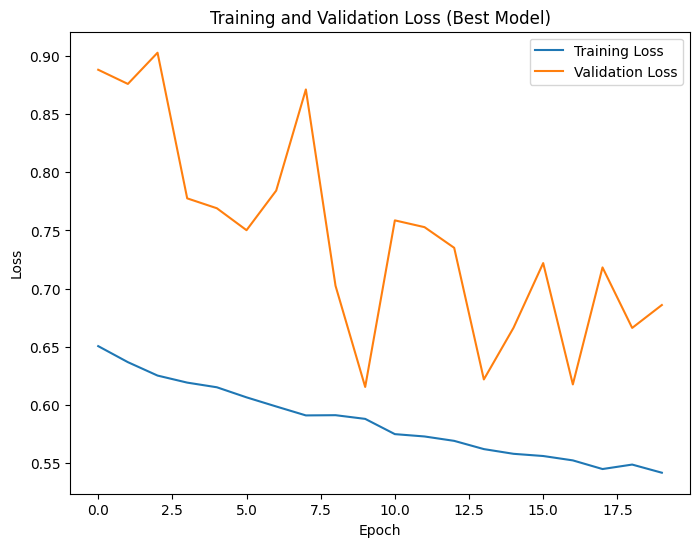

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
ROC AUC Score: 0.5186805128814207
              precision    recall  f1-score   support

           0       0.11      0.07      0.08       197
           1       0.83      0.90      0.86       983

    accuracy                           0.76      1180
   macro avg       0.47      0.48      0.47      1180
weighted avg       0.71      0.76      0.73      1180



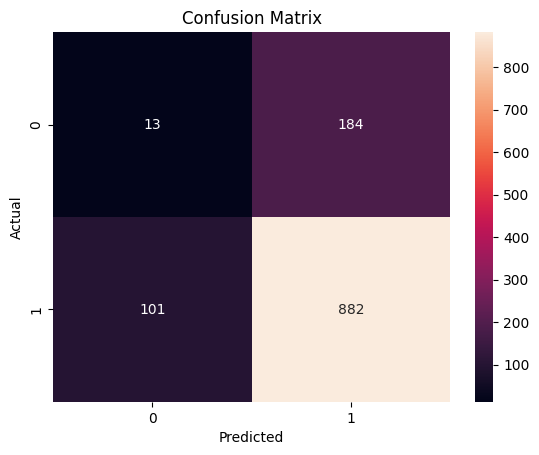

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer: 1181it [03:58,  4.71it/s]


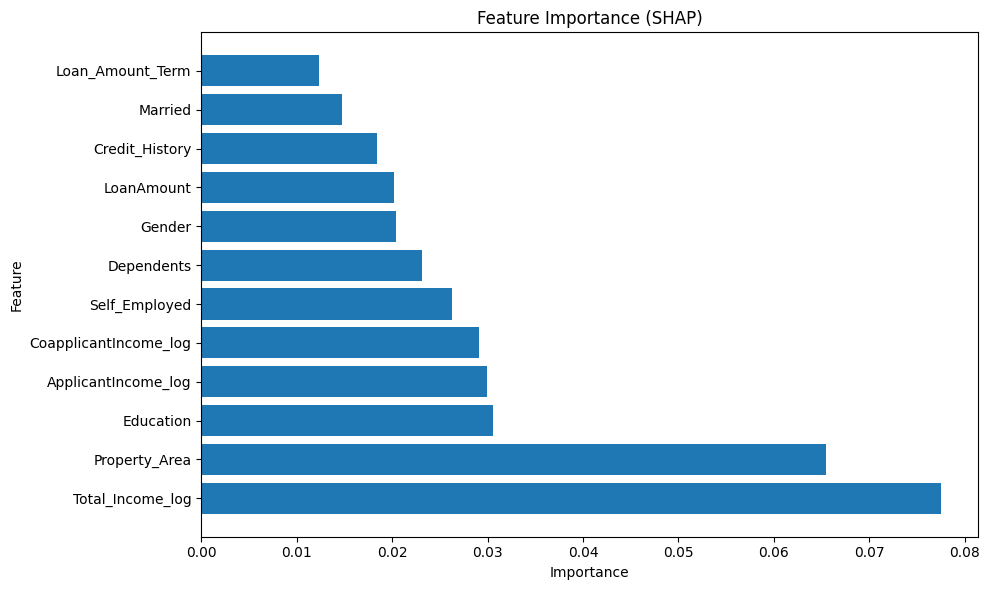

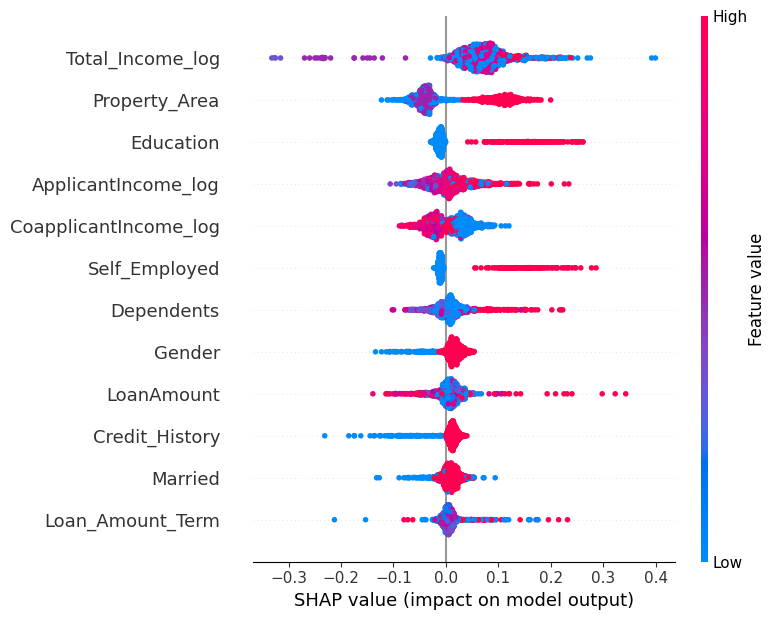

In [ ]:
# Define the model-building function for Keras Tuner
def model_builder(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                    activation='relu', input_shape=(X_resampled.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=16, max_value=64, step=16),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Create a Keras Tuner instance (e.g., RandomSearch)
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=50,
    directory='my_dir',
    project_name='loan_prediction_hyperband'
)

# tuner = kt.RandomSearch(
#     model_builder,
#     objective='val_accuracy',
#     max_trials=10,
#     directory='my_dir',
#     project_name='loan_prediction'
# )

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

tuner.search(X_resampled, y_resampled,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping]
             )
history_list = []
for i in range(tuner.oracle.get_space().num_initial_points):
    trial = tuner.oracle.get_trial(tuner.oracle.trials[i].trial_id)
    hp = trial.hyperparameters
    model = tuner.hypermodel.build(hp)

    history = model.fit(X_resampled, y_resampled,
                        epochs=50,
                        validation_split=0.2,
                        callbacks=[early_stopping]
                        )
    history_list.append(history)


for i, history in enumerate(history_list):
  plt.figure(figsize=(8, 6))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'trial {i + 1} - Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc}")

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_resampled.values,
    feature_names=X_resampled.columns,
    class_names=['0', '1'],
    discretize_continuous=True
)

# Explain an instance using LIME
i = 10

# Wrap model.predict to return probabilities for both classes
def predict_fn(x):
    probs = model.predict(x)
    return np.hstack([1 - probs, probs])

exp = explainer.explain_instance(X_test.values[i], predict_fn, num_features=10)
exp.show_in_notebook(show_table=True, show_all=False)


# Initialize SHAP explainer
explainer = shap.Explainer(model, X_resampled)

# Calculate SHAP values
shap_values = explainer(X_test)
feature_importance = np.mean(np.abs(shap_values.values), axis=0)
feature_importance_df = pd.DataFrame({
       'Feature': X_test.columns,
       'Importance': feature_importance
   })
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (SHAP)')
plt.tight_layout()
plt.show()

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)